# Forecast **AAPL** stock

Fine-tuned model: https://drive.google.com/drive/folders/1Di09f_7f2wqDtsTu_p0yDpTDQf8H7lT1?usp=sharing

# **Importing libraries**

In [ ]:
# ---------------------------- punkt ERROR

# ----------- STEP 1
!pip uninstall -y nltk
!rm -rf /root/nltk_data

!pip install nltk

Found existing installation: nltk 3.9.1
Uninstalling nltk-3.9.1:
  Successfully uninstalled nltk-3.9.1
  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)


In [ ]:
# ----------- STEP 2
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

In [ ]:
# ----------- STEP 3: CHECKING
from nltk.tokenize import word_tokenize
text = "Hello, this is a test sentence."

tokens = word_tokenize(text)

print(tokens)

['Hello', ',', 'this', 'is', 'a', 'test', 'sentence', '.']


In [28]:
!pip3 install sumy keras optuna

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.5 MB/s eta 0:00:00
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21692 sha256=2a945e48e5f0f74a1b5ca70154beeaf805efacedfc9a2d9586ba190a4a8b38c2
  Stored in directory: /root/.cache/pip/wheels/64/22/90/b84fcc30e16598db20a0d41340616dbf9b1e82bbcc627b0b33
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=77369f176e3e840d196910d0e5cc6ff53d3c0c85a7a14d7febf255b872654f98
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506

In [29]:
import os
import time

from datetime import timedelta, datetime

import pandas as pd
import numpy as np
import chardet

import requests

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

import optuna

from sklearn.model_selection import train_test_split

In [30]:
#Three libraries that will help us to summarize the news

from sumy.summarizers.lsa import LsaSummarizer
from sumy.nlp.tokenizers import Tokenizer
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.stemmers import Stemmer
from collections import defaultdict
from sumy.utils import get_stop_words

from transformers import BartForConditionalGeneration, BartTokenizer
from transformers import BertForSequenceClassification, BertTokenizer
from transformers import T5Tokenizer, T5ForConditionalGeneration

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam, RMSprop

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [66]:
import torch

import torch.nn as nn
from torch.nn.functional import softmax
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# **Helping functions and lists**

### After a quick inspection of dataset, there where some terminologies like: EST that might indicate on timezones

In [ ]:
"""

import nltk
import ssl

# Fix SSL issue
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Download 'punkt'
nltk.download('punkt')

"""

"\n\nimport nltk\nimport ssl\n\n# Fix SSL issue\ntry:\n    _create_unverified_https_context = ssl._create_unverified_context\nexcept AttributeError:\n    pass\nelse:\n    ssl._create_default_https_context = _create_unverified_https_context\n\n# Download 'punkt'\nnltk.download('punkt')\n\n"

In [ ]:
# The original datasets
raw_news_path = '/content/drive/MyDrive/TS-project/news_data_raw/'
raw_price_path = '/content/drive/MyDrive/TS-project/stock_price_data_raw/'

#Data used for finetuning the sentiment model
synthetic_data_finetune = '/content/drive/MyDrive/TS-project/synthetic_news_sentiment_dataset-2.csv'

In [ ]:
#later will used
formats = [
    '%B %d, %Y — %I:%M %p',  # "September 12, 2023 — 06:15 pm"
    '%b %d, %Y %I:%M%p',  # "Nov 14, 2023 7:35AM"
    '%d-%b-%y',  # "6-Jan-22"
    '%Y-%m-%d',  # "2021-4-5"
    '%Y/%m/%d',  # "2021/4/5"
    '%b %d, %Y'  # "DEC 7, 2023"
]

In [ ]:
file_path = os.path.join("", "")

df = pd.read_csv(raw_news_path + "aa.csv", on_bad_lines="warn")
df.columns = df.columns.str.lower()
if 'datetime' in df.columns:
    df.rename(columns={'datetime': 'date'}, inplace=True)

In [ ]:
df['date'].str.split(' ',expand=True)[6].unique()

array(['EST', 'EDT', None], dtype=object)

* EST - Eastern Daylight Time
* EDT - Daylight Saving Time

It will help us to remove the time differences.

In [ ]:
#removing the time diff.
def convert_to_utc_datetime(time_str, formats=formats):
    if "EDT" in time_str:
        time_str_cleaned = time_str.replace(' EDT','')
        offset = timedelta(hours=-4)
    elif "EST" in time_str:
        time_str_cleaned = time_str.replace(' EST','')
        offset =timedelta(hours=-5)
    else:
        time_str_cleaned = time_str
        offset = timedelta(hours=0)


    for fmt in formats:
        try:
            dt = datetime.strptime(time_str_cleaned, fmt)
            # if the date contains only dates without time
            if fmt == '%d-%b-%y':
                offset = timedelta(hours=0)

            dt_utc = dt + offset

            return dt_utc.strftime('%Y-%m-%d %H:%M:%S UTC')

        except ValueError:
            continue

    # if there is no corresponding date format, return an error
    return "Invalid date format"

In [ ]:
#init function
def df_date_convert(folder_path, saving_path):
    csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

    for csv_file in csv_files:
        print('Starting: ' + csv_file)
        file_path = os.path.join(folder_path,csv_file)

        df_temp = pd.read_csv(file_path, on_bad_lines="warn")
        df_temp.columns = df_temp.columns.str.lower()

        if "datetime" in df_temp.columns:
            df_temp.rename({'datetime':'date'}, inplace=True)

        df_temp['date'] = df_temp['date'].apply(convert_to_utc_datetime)

        df_temp['date'] = pd.to_datetime(df_temp['date'], utc=True)
        df_temp = df_temp.sort_values(by='date', ascending=False)

        df_temp.to_csv(os.path.join(saving_path, csv_file), index=False)
        print('DONE: ', csv_file)

In [ ]:
def metrics(test, prediction)->pd.DataFrame:
    mae = mean_absolute_error(test, prediction)
    mse = mean_squared_error(test, prediction)
    r2 = r2_score(test, prediction)

    data = {'eval':['MAE','MSE','R2'], 'score':[mae,mse,r2]}
    results = pd.DataFrame(data)
    return results

def plot_arima_results(train, test, prediction, target_column):

    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train, label='Train', color='blue')
    plt.plot(test.index, test, label='Test', color='green')
    plt.plot(test.index, prediction, label='Predicted', color='red', linestyle='dashed')
    plt.title(f"Optimized ARIMA Prediction ({target_column})")
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.legend()
    plt.show();


def plot_TSMixer_results(predicted_prices_df, date, actual, predicted):

    plt.figure(figsize=(12, 6))
    plt.plot(predicted_prices_df[date], predicted_prices_df[actual], label='Actual Close Price')
    plt.plot(predicted_prices_df[date], predicted_prices_df[predicted], label='Predicted Close Price')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Actual vs Predicted Close Prices')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_predictions_LSTM(y_test, predictions, title="Prediction vs True Values"):

    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label="True Values", color="blue")
    plt.plot(predictions, label="Predictions", color="orange")
    plt.title(title)
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

# Converting the datetime

In [ ]:
if __name__ == "__main__":
    news_saving_path = '/content/drive/MyDrive/TS-project/news_data_preprocessed'
    stock_saving_path = '/content/drive/MyDrive/TS-project/stock_price_data_preprocessed'
try:
  df_date_convert(raw_news_path, news_saving_path)
  df_date_convert(raw_price_path, stock_saving_path)
except:
  os.makedirs(news_saving_path, exist_ok=True)
  os.makedirs(stock_saving_path, exist_ok=True)

  df_date_convert(raw_news_path, news_saving_path)
  df_date_convert(raw_price_path, stock_saving_path)

Starting: aa.csv
DONE:  aa.csv
Starting: aa.csv
DONE:  aa.csv
Starting: aapl.csv
DONE:  aapl.csv


---

# **Text summary**

https://medium.com/@sarowar.saurav10/6-useful-text-summarization-algorithm-in-python-dfc8a9d33074

### As recommended AI-based are much better.

We conducted a comparison of three text summarization models: BART, T5, and SUMY. The evaluation was summarized using ChatGPT-4.



- The comparison involved testing and evaluating the performance of the models.
- Among the models, the SUMY algorithm demonstrated the highest precision.<br><br>

Below, we outline the functions used for text summarization.

In [ ]:
text_main = """

Tesla has posted strong earnings in the first quarter of 2024, reporting a revenue of $25 billion,
up 15% compared to the same period last year. The company announced that its Model Y sales grew by
20%, contributing to the overall revenue surge. Despite the positive results, Tesla faces challenges
in scaling up its production of batteries, which could affect future growth prospects. Tesla’s stock price
rose by 10% in the aftermath of the earnings report, reflecting investor optimism. Analysts are closely
monitoring the company’s expansion in Europe and its plans to build new factories in Asia.

"""

In [ ]:
model_name="sshleifer/distilbart-cnn-12-6"

# Load the tokenizer and model
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

## Bart

In [ ]:
def bart_summary(text):
    inputs = tokenizer.encode(
        "Summarize each important information from the text and keep the name of companies: " + text,
        return_tensors="pt",
        max_length=512,
        truncation=True)

    summary_ids = model.generate(
        inputs,
        max_length=150,
        min_length=30,
        length_penalty=2.0,
        num_beams=4,
        early_stopping=True)

    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    return summary



def from_csv_summarize(folder_path=None, saving_path=None, tokenizer=tokenizer, model=model, test_df=text_main):

#     csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
#     a = time.time()

#     for csv_file in csv_files:
#         print(csv_file)
#         file_path = os.path.join(folder_path, csv_file)

#         try:
#             temp = pd.read_csv(file_path, encoding="utf-8")
#         except UnicodeDecodeError:
#             temp = pd.read_csv(file_path, encoding="Windows-1252")

        # test_df = test_df.text.apply(bart_summary)

        test_df = bart_summary(test_df)

        return test_df


In [ ]:
bart_summary = from_csv_summarize()

## T5

In [ ]:
model_name = 't5-base'
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
financial_report = text_main

def summarize_text(text):
    inputs = tokenizer.encode("summarize and do not forget to add the name of the comapy related: " + text, return_tensors="pt", max_length=512, truncation=True)

    summary_ids = model.generate(
        inputs,
        max_length=100,
        min_length=50,
        length_penalty=2.0,
        num_beams=4,
        early_stopping=True)

    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

t5 = summarize_text(financial_report)

print(t5)

Tesla has posted strong earnings in the first quarter of 2024, reporting a revenue of $25 billion, up 15% compared to the same period last year . despite the positive results, Tesla faces challenges in scaling up its production of batteries, which could affect future growth prospects .


## Sumy

This code implements a text summarization pipeline using the LSA Summarizer (Latent Semantic Analysis) and additional custom weighting for key phrases. It also processes multiple CSV files in a folder, applies the summarization on the text column, and saves the results in a new CSV file.



- Stemmer: Reduces words to their root forms for better text processing.
- Summarizer: Uses Latent Semantic Analysis (LSA) for text summarization.
- Tokenizer: Breaks text into sentences for processing.
- Stop Words: Excludes common, insignificant words (e.g., "the", "is") from analysis.






In [ ]:
# Initialize LexRankSummarizer and Tokenizer
stemmer = Stemmer("english")
summarizer = LsaSummarizer(stemmer)
tokenizer = Tokenizer("english")
summarizer.stop_words = get_stop_words("english")

# Boosts the importance of sentences containing specific keywords.
def increase_weight_for_key_words(sentences, key_words):
    sentence_weights = defaultdict(float)

    for sentence in sentences:
        for word in key_words:
            if word.lower() in str(sentence).lower():
                sentence_weights[sentence] += 1
    return sentence_weights


# Creates summaries by combining an initial LSA-based summary with keyword-weighted sentences.
def new_sum(text, key_words, num_sentences):
    parser = PlaintextParser.from_string(text, tokenizer)
    initial_summary = summarizer(parser.document, num_sentences)

    # Increase weight
    sentence_weights = increase_weight_for_key_words(parser.document.sentences, key_words)

    # Combine weights from initial summary with additional weights
    for sentence in initial_summary:
        sentence_weights[sentence] += 1  # Initial summary sentences get additional weight

    # Select top sentences as final summary
    final_summary = sorted(sentence_weights, key=sentence_weights.get, reverse=True)[:num_sentences]

    # Output final summary
    final_summary_text = " ".join(str(sentence) for sentence in final_summary)

    return final_summary_text

# Processes multiple CSV files, generates summaries for text columns, cleans the data, and saves the results.
def from_csv_summarize(folder_path, saving_path):

    csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
    a = time.time()

    for csv_file in csv_files:
        print(csv_file)
        file_path = os.path.join(folder_path, csv_file)

        try:
            df = pd.read_csv(file_path, encoding="utf-8")
        except UnicodeDecodeError:
            df = pd.read_csv(file_path, encoding="Windows-1252")
        symbol = csv_file.split(".")[0].lower()

        # AAPL - dataset is used
        df.columns = df.columns.str.lower()
        key_words_value = {symbol}
        num_sentences_value = 3

        df['new_text'] = df['text'].apply(new_sum, key_words=key_words_value, num_sentences=num_sentences_value)

        # Drop the old text column
        df = df.drop(columns=['text'])

        # Keep only those rows that are not empty
        df = df[df['mark'] == 1]
        print(time.time()-a, "s") # Timing of the whole proccess

        df.to_csv(os.path.join(saving_path, symbol.lower()+".csv"), index=False)

In [ ]:
if __name__ == "__main__":
  news_read_path = "/content/drive/MyDrive/TS-project/news_data_preprocessed"
  news_saving_path = "/content/drive/MyDrive/TS-project/news_data_summarized"

  try:
    from_csv_summarize(news_read_path, news_saving_path)
  except:
    os.makedirs(news_saving_path, exist_ok=True)
    from_csv_summarize(news_read_path, news_saving_path)

aa.csv
97.39212441444397 s


----

# **Sentiment**

### We will be using the example from our course. Model and fine-tuning functions are used from the course, and **we have added saving the fine-tuned model and uploading functions** <br><br>

The dataset for fine-tuning is created by the help of ChatGPT-4o. <br><br>

The results are too high even without fine-tuning. I guess, the model is too good for our news. There was no need to fine-tune it, however, we did it.


In [ ]:
# Загрузка предобученной модели и токенизатора FinBERT
model_name = 'yiyanghkust/finbert-tone'  # Финансовая версия модели BERT, обученная для анализа новостей
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name).to(device)

# Пример финансовых новостей (положительные и отрицательные)
news = [
    "Company X's revenue has surged by 25% this quarter, exceeding market expectations.",  # Положительное влияние
    "Stock prices of Company Y are falling after reports of poor quarterly earnings.",  # Отрицательное влияние
    "Vanguard S&P Mid-Cap 400 Value ETF IVOV $84.24 $92.34 9.61% Black Hills Corporation BKH $51.58 $59.83 16.00% Alcoa Corporation AA $27.87 $32.05 15.00% Southwest Gas Holdings, Inc. SWX $60.80 $69.67 14.58% Are analysts justified in these targets, or overly optimistic about where these stocks will be trading 12 months from now? Three of IVOV's underlying holdings with notable upside to their analyst target prices are Black Hills Corporation (Symbol: BKH), Alcoa Corporation (Symbol: AA), and Southwest Gas Holdings, Inc. (Symbol: SWX). Similarly, AA has 15.00% upside from the recent share price of $27.87 if the average analyst target price of $32.05/share is reached, and analysts on average are expecting SWX to reach a target price of $69.67/share, which is 14.58% above the recent price of $60.80.1"
]

# Функция для классификации новостей
def classify_financial_news(news_article):
    # Токенизация
    inputs = tokenizer(news_article, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

    # Прогноз
    with torch.no_grad():
        logits = model(**inputs).logits

    # Преобразуем логиты в вероятности с помощью softmax
    probs = softmax(logits, dim=-1)
    return probs

# Применяем классификацию к каждой новости
for article in news:
    probs = classify_financial_news(article)
    positive_prob = probs[0][1].item()  # Вероятность положительного влияния
    negative_prob = probs[0][0].item()  # Вероятность отрицательного влияния

    print(f"Новость: '{article}'")
    print(f"Вероятность положительного влияния: {positive_prob:.4f}, Вероятность отрицательного влияния: {negative_prob:.4f}")

    if positive_prob > negative_prob:
        print("Новость оказывает положительное влияние на рынок.\n")
    else:
        print("Новость оказывает отрицательное влияние на рынок.\n")


vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

Новость: 'Company X's revenue has surged by 25% this quarter, exceeding market expectations.'
Вероятность положительного влияния: 1.0000, Вероятность отрицательного влияния: 0.0000
Новость оказывает положительное влияние на рынок.

Новость: 'Stock prices of Company Y are falling after reports of poor quarterly earnings.'
Вероятность положительного влияния: 0.0002, Вероятность отрицательного влияния: 0.8483
Новость оказывает отрицательное влияние на рынок.

Новость: 'Vanguard S&P Mid-Cap 400 Value ETF IVOV $84.24 $92.34 9.61% Black Hills Corporation BKH $51.58 $59.83 16.00% Alcoa Corporation AA $27.87 $32.05 15.00% Southwest Gas Holdings, Inc. SWX $60.80 $69.67 14.58% Are analysts justified in these targets, or overly optimistic about where these stocks will be trading 12 months from now? Three of IVOV's underlying holdings with notable upside to their analyst target prices are Black Hills Corporation (Symbol: BKH), Alcoa Corporation (Symbol: AA), and Southwest Gas Holdings, Inc. (Symbo

In [ ]:
# Загрузка предобученной модели и токенизатора FinBERT
model_name = 'yiyanghkust/finbert-tone'  # Финансовая версия модели BERT, обученная для анализа новостей
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name).to(device)

# Пример финансовых новостей (положительные и отрицательные)
news = [
    "Company X's revenue has surged by 25% this quarter, exceeding market expectations.",  # Положительное влияние
    "Stock prices of Company Y are falling after reports of poor quarterly earnings.",  # Отрицательное влияние
    """
        Vanguard S&P Mid-Cap 400 Value ETF IVOV $84.24 $92.34 9.61% Black Hills\n
        Corporation BKH $51.58 $59.83 16.00% Alcoa Corporation AA $27.87 $32.05 15.00% Southwest Gas Holdings, Inc.\n
        SWX $60.80 $69.67 14.58% Are analysts justified in these targets, or overly optimistic about where these\n
        stocks will be trading 12 months from now? Three of IVOV's underlying holdings with notable upside to\n
        their analyst target prices are Black Hills Corporation (Symbol: BKH), Alcoa Corporation (Symbol: AA),\n
        and Southwest Gas Holdings, Inc. (Symbol: SWX). Similarly, AA has 15.00% upside from the recent\n
        share price of $27.87 if the average analyst target price of $32.05/share is reached, and analysts on average\n
        \are expecting SWX to reach a target price of $69.67/share, which is 14.58% above the recent price of $60.80.\n
    """,
]

# Функция для классификации новостей
def classify_financial_news(news_article):
    # Токенизация
    inputs = tokenizer(news_article, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

    # Прогноз
    with torch.no_grad():
        logits = model(**inputs).logits

    # Преобразуем логиты в вероятности с помощью softmax
    probs = softmax(logits, dim=-1)
    return probs

# Применяем классификацию к каждой новости
for article in news:
    probs = classify_financial_news(article)
    positive_prob = probs[0][1].item()  # Вероятность положительного влияния
    negative_prob = probs[0][0].item()  # Вероятность отрицательного влияния

    print(f"Новость: '{article}'")
    print(f"Вероятность положительного влияния: {positive_prob:.4f}, Вероятность отрицательного влияния: {negative_prob:.4f}")

    if positive_prob > negative_prob:
        print("Новость оказывает положительное влияние на рынок.\n")
    else:
        print("Новость оказывает отрицательное влияние на рынок.\n")

# Новость: 'Company X's revenue has surged by 25% this quarter, exceeding market expectations.'
# Вероятность положительного влияния: 1.0000, Вероятность отрицательного влияния: 0.0000
# Новость оказывает положительное влияние на рынок.

# Новость: 'Stock prices of Company Y are falling after reports of poor quarterly earnings.'
# Вероятность положительного влияния: 0.0002, Вероятность отрицательного влияния: 0.8483
# Новость оказывает отрицательное влияние на рынок.

Новость: 'Company X's revenue has surged by 25% this quarter, exceeding market expectations.'
Вероятность положительного влияния: 1.0000, Вероятность отрицательного влияния: 0.0000
Новость оказывает положительное влияние на рынок.

Новость: 'Stock prices of Company Y are falling after reports of poor quarterly earnings.'
Вероятность положительного влияния: 0.0002, Вероятность отрицательного влияния: 0.8483
Новость оказывает отрицательное влияние на рынок.

Новость: '
        Vanguard S&P Mid-Cap 400 Value ETF IVOV $84.24 $92.34 9.61% Black Hills

        Corporation BKH $51.58 $59.83 16.00% Alcoa Corporation AA $27.87 $32.05 15.00% Southwest Gas Holdings, Inc.

        SWX $60.80 $69.67 14.58% Are analysts justified in these targets, or overly optimistic about where these

        stocks will be trading 12 months from now? Three of IVOV's underlying holdings with notable upside to

        their analyst target prices are Black Hills Corporation (Symbol: BKH), Alcoa Corporation (Symbol:

In [ ]:
# generated by ChatGPT-4o
finance_news = pd.read_csv('/content/drive/MyDrive/TS-project/synthetic_news_sentiment_dataset-2.csv')
finance_news.head()

,news,sentiment
0,Technopolis plans to develop in stages an area...,neutral
1,Layoffs were announced as the company struggle...,negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,"According to Gran , the company has no plans t...",neutral
4,Production was halted due to ongoing labor dis...,negative


In [ ]:
X = finance_news['news'].to_list()
y = finance_news['sentiment'].to_list()

labels = {0:'neutral', 1:'positive',2:'negative'}

sent_val = list()
num_news = 0
for x in X:
    inputs = tokenizer(x, return_tensors="pt", padding=True).to(device)
    outputs = model(**inputs)[0]

    val = labels[np.argmax(outputs.detach().cpu().numpy())]

    if num_news<10:
      print(x, '----', val)
      print('#######################################################')
      num_news+=1
    sent_val.append(val)

print(accuracy_score(y, sent_val))

Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said . However, no major changes in operations are expected. ---- neutral
#######################################################
Layoffs were announced as the company struggles to maintain profitability in a competitive market. This situation raises concerns about the company's future. ---- negative
#######################################################
For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m . This indicates strong growth potential for the company. ---- positive
#######################################################
According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing . However, n

## **1.0 - HIGH!!!!**

# **Fine-tuning**

In [ ]:
# Проверяем устройство (используем GPU, если доступно)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Загружаем предобученный токенизатор и модель FinBERT
model_name = "yiyanghkust/finbert-tone"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3).to(device)

# Загружаем данные
finance_news = pd.read_csv('/content/drive/MyDrive/TS-project/synthetic_news_sentiment_dataset-2.csv')
X = finance_news['news'].to_list()
y = finance_news['sentiment'].to_list()


# Define a label mapping dictionary
labels = {'neutral': 0, 'positive': 1, 'negative': 2}

# Convert labels to integers using the mapping
y = [labels[label] for label in y]

# Dataset for financial news
class FinanceNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels  # Now labels are integers
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]  # label is already an integer
        # Tokenize text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "label": torch.tensor(label, dtype=torch.long)  # Label is converted to a long tensor
        }

# Создаем обучающую и тестовую выборки
dataset = FinanceNewsDataset(X, y, tokenizer)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

# Определяем оптимизатор и функцию потерь
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# Функция для обучения модели
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Прямой проход
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        total_loss += loss.item()

        # Обратное распространение ошибки
        loss.backward()
        optimizer.step()

    return total_loss / len(dataloader)

# Функция для оценки модели
def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            label = batch["label"].to(device)

            # Прямой проход
            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=-1)

            preds.extend(predictions.cpu().numpy())
            labels.extend(label.cpu().numpy())

    accuracy = accuracy_score(labels, preds)
    report = classification_report(labels, preds, target_names=['neutral', 'positive', 'negative'])
    return accuracy, report

# Запускаем процесс обучения и оценки
epochs = 3
for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss:.4f}")

    accuracy, report = evaluate(model, test_loader, device)
    print(f"Accuracy on test set: {accuracy:.4f}")
    print("Classification Report:\n", report)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

Epoch 1/3, Training Loss: 0.0000
Accuracy on test set: 1.0000
Classification Report:
               precision    recall  f1-score   support

     neutral       1.00      1.00      1.00       221
    positive       1.00      1.00      1.00       215
    negative       1.00      1.00      1.00       164

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



In [ ]:
if __name__ == "__main__":
  finetuned_model_path = "/content/drive/MyDrive/TS-project/finetuned_finbert_model/"

  try:
    model.save_pretrained(finetuned_model_path)
    tokenizer.save_pretrained(finetuned_model_path)


  except:
    os.makedirs(finetuned_model_path, exist_ok=True)

    model.save_pretrained(finetuned_model_path)
    tokenizer.save_pretrained(finetuned_model_path)


# Save the fine-tuned model and tokenizer

print("Model and tokenizer saved to '/content/drive/MyDrive/TS-project/finetuned_finbert_model/'")

NameError: name 'model' is not defined

In [ ]:
# Load the fine-tuned model and tokenizer
model_sen = BertForSequenceClassification.from_pretrained(finetuned_model_path)
tokenizer_sen = BertTokenizer.from_pretrained(finetuned_model_path)

# Move model to the appropriate device (GPU/CPU)
device_sen = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_sen = model_sen.to(device)

print("Fine-tuned model and tokenizer loaded successfully.")

Fine-tuned model and tokenizer loaded successfully.


In [ ]:
def predict_sentiment(text, model=model_sen, tokenizer=tokenizer_sen, device=device_sen):
    model.eval()  # Put the model in evaluation mode
    with torch.no_grad():
        # Tokenize and prepare the input
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)

        # Get model predictions
        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1).cpu().item()

        # Map prediction back to label
        label_map = {0: "neutral", 1: "positive", 2: "negative"}
        return label_map[predictions]


def from_csv_sentiment(folder_path, saving_path, model_sen=model_sen, tokenizer_sen=tokenizer_sen, device_sen=device_sen):

    csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
    a = time.time()

    for csv_file in csv_files:

        print(csv_file)
        file_path = os.path.join(folder_path, csv_file)

        try:
            df = pd.read_csv(file_path, encoding="utf-8")
        except UnicodeDecodeError:
            df = pd.read_csv(file_path, encoding="Windows-1252")
        symbol = csv_file.split(".")[0].lower()

        # AAPL - dataset is used
        df.columns = df.columns.str.lower()

        df['sentiment'] = df['new_text'].apply(predict_sentiment)

        # Define a label mapping dictionary
        labels = {'neutral': 0, 'positive': 1, 'negative': 2}

        # Convert labels to integers using the mapping
        df['sentiment'] = df['sentiment'].map(labels)

        df.to_csv(os.path.join(saving_path, symbol.lower()+".csv"), index=False)


if __name__ == "__main__":
  news_read_path = "/content/drive/MyDrive/TS-project/news_data_summarized"
  news_saving_path = '/content/drive/MyDrive/TS-project/news_data_summarized_sentiment'

  try:
    from_csv_sentiment(news_read_path, news_saving_path)

  except:
    os.makedirs(news_saving_path, exist_ok=True)

    from_csv_sentiment(news_read_path, news_saving_path)

AA.csv


In [ ]:
# ! ------------------------- HERE ---- DELETE



t_df = pd.read_csv(r'/content/drive/MyDrive/TS-project/news_data_summarized_sentiment/AA.csv')
# Define a label mapping dictionary
labels = {'neutral': 2, 'positive': 3, 'negative': 1}
t_df['sentiment'] = t_df['sentiment'].map(labels)


t_df.to_csv("/content/drive/MyDrive/TS-project/news_data_summarized_sentiment/aa.csv", index=False)

# Combining the news with the stocks dataset

In [ ]:
# Localization of time
def convert_to_utc(df, date_column):
    print('Entered to convert_to_utc function')
    """
    Changing into UTC format
    """
    df[date_column] = pd.to_datetime(df[date_column])

    if df[date_column].dt.tz is None:  # Checking whether it is UTC formatted date
        df[date_column] = df[date_column].dt.tz_localize('UTC')
    return df



# The exponential decay method is preferable as the older data (news) quickly become irrelevant
def fill_missing_dates_with_exponential_decay(df, date_column, sentiment_column, decay_rate=0.05):
    print('Entered to fill_missing_dates_with_exponential_decay function')

    # Ensure that the datetime column has a correct format
    df[date_column] = pd.to_datetime(df[date_column])

    # Creating complete date range
    # Adds missing dates within the range for time-series continuity
    date_range = pd.date_range(start=df[date_column].min(), end=df[date_column].max())

    # Crating a df containing all dates
    # Combines the existing data with the full date range
    full_df = pd.DataFrame(date_range, columns=[date_column])
    full_df = pd.merge(full_df, df, on=date_column, how='left')

    # Creating a "news_flag" column
    # Flags and helps to identify the actual news data
    full_df['news_flag'] = full_df[sentiment_column].notna().astype(int)

    # Fill missing sentiment values using an exponential decay rule
    # Estimates missing sentiment values based on exponential decay over time
    last_valid_sentiment = None
    last_valid_date = None
    for i, row in full_df.iterrows():
        if pd.isna(row[sentiment_column]):
            if last_valid_sentiment is not None:
                days_since_last_valid = (row[date_column] - last_valid_date).days
                decayed_sentiment = 0
                decayed_sentiment = 3 + (last_valid_sentiment - 3) * np.exp(-decay_rate * days_since_last_valid)
                full_df.at[i, sentiment_column] = decayed_sentiment
                full_df.at[i, 'news_flag'] = 0
        else:
            last_valid_sentiment = row[sentiment_column]
            last_valid_date = row[date_column]
    return full_df


def integrate_data(stock_price_df, news_df, stock_price_csv_file):
    print('Entered to integrate_data function')

    # Create a copy of the original DataFrame
    # Prevents modifying the original dataset directly
    stock_price_df_copy = stock_price_df.copy()
    news_df_copy = news_df.copy()

    # Convert date formats and sort the data
    # Ensures consistency and proper alignment of data
    stock_price_df_copy = convert_to_utc(stock_price_df_copy, 'date')
    news_df_copy = convert_to_utc(news_df_copy, 'date')

    stock_price_df_copy['date'] = pd.to_datetime(stock_price_df_copy['date'])
    news_df_copy['date'] = pd.to_datetime(news_df_copy['date'])

    # To align datetime to the start of the day
    stock_price_df_copy['date'] = pd.to_datetime(stock_price_df_copy['date']).dt.normalize()
    news_df_copy['date'] = pd.to_datetime(news_df_copy['date']).dt.normalize()

    stock_price_df_copy.set_index('date', inplace=True)
    news_df_copy.set_index('date', inplace=True)

    # Sorting the dates
    stock_price_df_copy.sort_index(inplace=True)
    news_df_copy.sort_index(inplace=True)

    average_sentiment = news_df_copy.groupby('date')['sentiment'].mean().reset_index()

    # Fill missing dates using an exponential decay rule
    # Ensures sentiment continuity with decay for missing days
    average_sentiment_filled = fill_missing_dates_with_exponential_decay(average_sentiment, 'date', 'sentiment')

    # Merge the data
    # Combines stock prices with news sentiment data for modeling
    merged_df = pd.merge(stock_price_df_copy, average_sentiment_filled, on='date', how='left')

    # Replace NaN values with 3
    # Sets a neutral sentiment default where no data exists
    merged_df['sentiment'].fillna(0, inplace=True)

    # Drop rows with missing News_flag
    # Cleans up rows without proper sentiment values
    df_cleaned = merged_df.dropna(subset=['news_flag'])

    # Filter out rows where sentiment is 0
    # Removes invalid sentiment data for analysis
    df_cleaned = df_cleaned[df_cleaned['sentiment'] != 0]
    # Values are scaled to fall approximately in the range [0, 1]
    df_cleaned['scaled_sentiment'] = df_cleaned['sentiment'].apply(lambda x: (x - 0.9999) / 4)


    df_cleaned.columns.str.lower()
    print(len(df_cleaned['close']))
    if len(df_cleaned['close']) < 333:
        print(stock_price_csv_file)
        print("Lower than 333")
        return 0, df_cleaned
    return 1, df_cleaned


def start_inte(stock_price_folder_path, news_folder_path, saving_path):
    # Read CSV files and process column names
    stock_price_csv_files = [file for file in os.listdir(stock_price_folder_path) if file.endswith('.csv')]
   
    for stock_price_csv_file in stock_price_csv_files:
        print(stock_price_csv_file)
        stock_file_path = os.path.join(stock_price_folder_path, stock_price_csv_file)
        stock_price_df = pd.read_csv(stock_file_path)
        stock_price_df.columns = stock_price_df.columns.str.lower()
        news_file_path = os.path.join(news_folder_path, stock_price_csv_file)



        if not os.path.isfile(news_file_path):
            print("No file storing corresponding stock news")
            continue
        news_df = pd.read_csv(news_file_path)
        news_df.columns = news_df.columns.str.lower()
        flag_333, merged_data = integrate_data(stock_price_df, news_df, stock_price_csv_file)
        merged_data.to_csv(os.path.join(saving_path, stock_price_csv_file), index=False)

In [ ]:
if __name__ == "__main__":
    stock_price_folder = "/content/drive/MyDrive/TS-project/stock_price_data_preprocessed"
    news_folder = "/content/drive/MyDrive/TS-project/news_data_summarized_sentiment"
    saving_path = "/content/drive/MyDrive/TS-project/price_news_integrate"


    try:
      start_inte(stock_price_folder, news_folder, saving_path)
    except:
      os.makedirs(saving_path, exist_ok=True)
      start_inte(stock_price_folder, news_folder, saving_path)

aa.csv
Entered to integrate_data function
Entered to convert_to_utc function
Entered to convert_to_utc function
Entered to fill_missing_dates_with_exponential_decay function


<ipython-input-72-ebf41a4da34d>:102: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['sentiment'].fillna(3, inplace=True)


1969
aa.csv
Entered to integrate_data function
Entered to convert_to_utc function
Entered to convert_to_utc function
Entered to fill_missing_dates_with_exponential_decay function


<ipython-input-72-ebf41a4da34d>:102: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['sentiment'].fillna(3, inplace=True)


1969
aapl.csv
No file storing corresponding stock news


# **Predictions**

## **1 - TSMixer**

In [60]:
scaler = MinMaxScaler()

In [58]:
df_predict = pd.read_csv(r'/content/drive/MyDrive/TS-project/price_news_integrate/aa.csv')

In [61]:
df_predict[['close', 'volume']] = scaler.fit_transform(df_predict[['close', 'volume']])

In [62]:
values = df_predict.drop('date', axis=1).values

In [63]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length, 0]  # Close price as target
        xs.append(x)
        ys.append(y)
    return torch.tensor(xs, dtype=torch.float32), torch.tensor(ys, dtype=torch.float32)

# Set the sequence length to 180 (amount of days to predict)
seq_length = 180
X, y = create_sequences(values, seq_length)

<ipython-input-63-98e9214adb3d>:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(xs, dtype=torch.float32), torch.tensor(ys, dtype=torch.float32)


In [64]:
train_size = int(X.shape[0] * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [67]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32)

In [68]:
class TSMixer(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(TSMixer, self).__init__()
        self.mixer = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=hidden_size, kernel_size=1),
            nn.ReLU(),
            *[nn.Sequential(
                nn.Conv1d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=1),
                nn.ReLU()) for _ in range(num_layers)],
            nn.Conv1d(in_channels=hidden_size, out_channels=output_size, kernel_size=1)
        )

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.mixer(x)
        x = x.transpose(1, 2)
        return x[:, -1, :]

In [69]:
input_size = X_train.shape[2]  # 770 features: Volume and Close price and 768 bert embedding
hidden_size = 64
num_layers = 2
output_size = 1

model = TSMixer(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [70]:
epochs = 50
for epoch in range(epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y.unsqueeze(1))
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

Epoch 1/50, Loss: 41.34623336791992
Epoch 2/50, Loss: 1.8063486814498901
Epoch 3/50, Loss: 0.6499075293540955
Epoch 4/50, Loss: 0.23232227563858032
Epoch 5/50, Loss: 1.8601739406585693
Epoch 6/50, Loss: 0.7751608490943909
Epoch 7/50, Loss: 0.44594109058380127
Epoch 8/50, Loss: 0.9577117562294006
Epoch 9/50, Loss: 0.415191113948822
Epoch 10/50, Loss: 0.6510542035102844
Epoch 11/50, Loss: 1.5237841606140137
Epoch 12/50, Loss: 0.8634103536605835
Epoch 13/50, Loss: 1.8739137649536133
Epoch 14/50, Loss: 0.4388118386268616
Epoch 15/50, Loss: 0.40085604786872864
Epoch 16/50, Loss: 0.6300002932548523
Epoch 17/50, Loss: 0.6785064339637756
Epoch 18/50, Loss: 0.7036895155906677
Epoch 19/50, Loss: 1.5126125812530518
Epoch 20/50, Loss: 0.2986927926540375
Epoch 21/50, Loss: 0.7358733415603638
Epoch 22/50, Loss: 0.8204812407493591
Epoch 23/50, Loss: 0.5200380086898804
Epoch 24/50, Loss: 1.031736135482788
Epoch 25/50, Loss: 0.27114102244377136
Epoch 26/50, Loss: 1.4164222478866577
Epoch 27/50, Loss: 0

In [73]:
# Step 6: Prediction
model.eval()
predictions = []
with torch.no_grad():
    for batch_X, _ in test_loader:
        pred = model(batch_X)
        predictions.append(pred)

# Convert predictions to a numpy array and invert normalization
# Create a placeholder for inverse scaling
predictions = torch.cat(predictions).numpy()

# Initialize an array of zeros with the same number of features as the original data
predicted_prices_full = np.zeros((predictions.shape[0], df_predict[['close', 'volume']].shape[1]))

# Place the predictions in the 'Close' column (3rd index)
predicted_prices_full[:, 0] = predictions[:, 0]

# Inverse transform
predicted_prices_full = scaler.inverse_transform(predicted_prices_full)

# Extract the 'Close' prices from the inverse-transformed data
predicted_prices = predicted_prices_full[:, 0]

# Convert predictions to a DataFrame and save to a CSV file
predicted_prices_df = pd.DataFrame(predicted_prices, columns=['predicted_close'])

  eval        score
0  MAE    58.652790
1  MSE  6309.161152
2   R2     0.989735


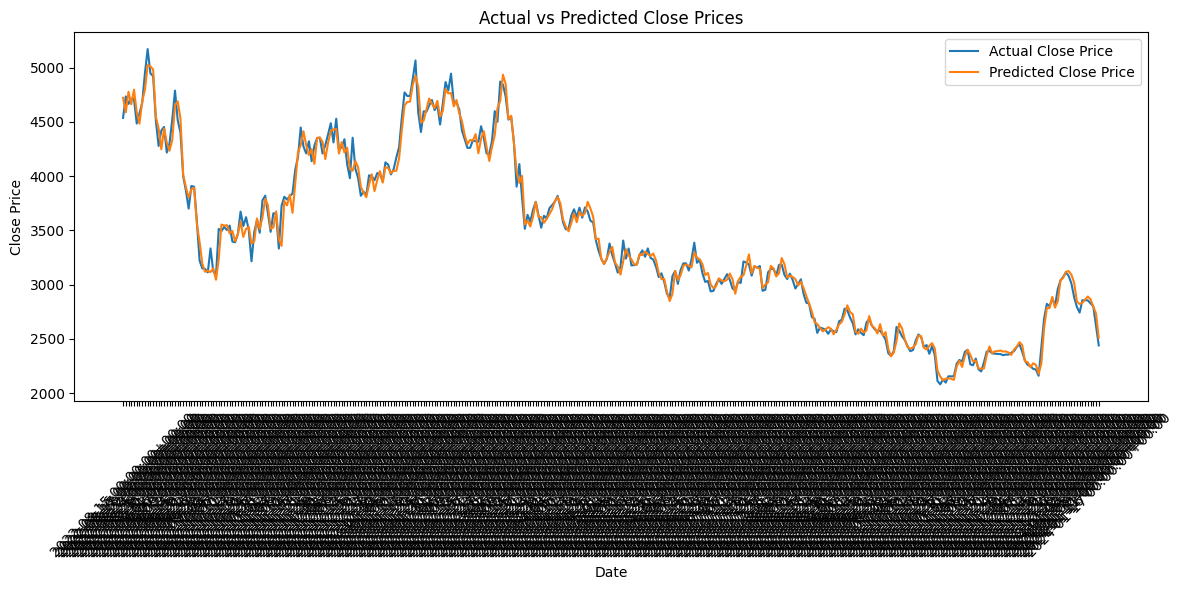

In [74]:
y_test_np = y_test.numpy().reshape(-1, 1)

# Create an array with the same shape as the original features, filled with zeros
y_test_full = np.zeros((y_test_np.shape[0], stock_data[['close', 'volume']].shape[1]))

# Place y_test_np in the Close column (assuming it's the 4th column as before)
y_test_full[:, 0] = y_test_np[:, 0]

# Apply inverse transform only on the relevant column
actual_prices_full = scaler.inverse_transform(y_test_full)

# Extract the actual Close prices
actual_prices = actual_prices_full[:, 0]

# Calculate the MSE between actual and predicted Close prices
results_eval = metrics(test=actual_prices, prediction=predicted_prices)
print(results_eval)

# Matching predictions with dates
predicted_dates = df_predict['date'].iloc[train_size + seq_length:].reset_index(drop=True)

# Combine dates, actual prices, and predicted prices into a DataFrame
predicted_prices_df = pd.DataFrame({
    'date': predicted_dates,
    'Actual_Close': actual_prices,
    'Predicted_Close': predicted_prices
})

# Visualization
plot_TSMixer_results(predicted_prices_df=predicted_prices_df, date='date', actual='Actual_Close', predicted='Predicted_Close')

## **2 - LSTM + hyperparams**

Training...


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/20], Loss: 0.0465
Epoch [2/20], Loss: 0.0342
Epoch [3/20], Loss: 0.0338
Epoch [4/20], Loss: 0.0339
Epoch [5/20], Loss: 0.0343
Epoch [6/20], Loss: 0.0337
Epoch [7/20], Loss: 0.0339
Epoch [8/20], Loss: 0.0339
Epoch [9/20], Loss: 0.0341
Epoch [10/20], Loss: 0.0336
Epoch [11/20], Loss: 0.0337
Epoch [12/20], Loss: 0.0341
Epoch [13/20], Loss: 0.0339
Epoch [14/20], Loss: 0.0339
Epoch [15/20], Loss: 0.0340
Epoch [16/20], Loss: 0.0339
Epoch [17/20], Loss: 0.0339
Epoch [18/20], Loss: 0.0339
Epoch [19/20], Loss: 0.0338
Epoch [20/20], Loss: 0.0336
Predicting...
MAE: 6.8062, MSE: 67.2995, R²: 0.0485


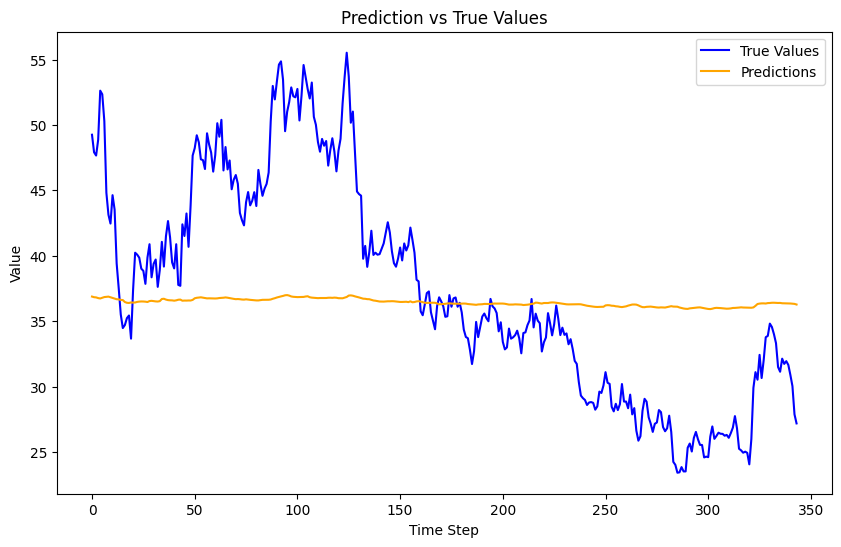

In [181]:
# Custom Dataset Class for Time Series
class TimeSeriesDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        sequence = self.data[idx:idx + self.sequence_length, :-1]  # Features
        target = self.data[idx + self.sequence_length, -1]  # Target
        return torch.tensor(sequence, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)


# Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Output from the last time step
        return out


# Prepare the Data
def prepare_data(df, sequence_length, test_size=0.2):
    # Normalize the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)

    # Split data into train and test
    train_data, test_data = train_test_split(scaled_data, test_size=test_size, shuffle=False)

    # Convert to PyTorch datasets
    train_dataset = TimeSeriesDataset(train_data, sequence_length)
    test_dataset = TimeSeriesDataset(test_data, sequence_length)

    return train_dataset, test_dataset, scaler


# Train the Model
def train_model(model, dataloader, criterion, optimizer, device, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for sequences, targets in dataloader:
            sequences, targets = sequences.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(dataloader):.4f}")


# Make Predictions
def predict(model, dataloader, device):
    model.eval()
    predictions = []
    y_test = []
    with torch.no_grad():
        for sequences, targets in dataloader:
            sequences = sequences.to(device)
            outputs = model(sequences)
            predictions.extend(outputs.cpu().numpy())
            y_test.extend(targets.numpy())
    return np.array(predictions).flatten(), np.array(y_test).flatten()


# Main Function
if __name__ == "__main__":
    # Load data
    df = pd.read_csv("/content/drive/MyDrive/TS-project/price_news_integrate/aa.csv")
    df = df[['open', 'high', 'low', 'close', 'adj close', 'volume', 'scaled_sentiment']]  # Select relevant columns
    target_column = 'close'

    # Append target column as the last column
    df['target'] = df[target_column]
    df = df.dropna()

    # Hyperparameters
    sequence_length = 50
    input_size = len(df.columns) - 1  # Exclude target
    hidden_size = 64
    num_layers = 2
    output_size = 1
    batch_size = 32
    learning_rate = 0.001
    epochs = 20

    # Prepare data
    train_dataset, test_dataset, scaler = prepare_data(df.values, sequence_length)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, criterion, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    print("Training...")
    train_model(model, train_loader, criterion, optimizer, device, epochs)

    # Make predictions
    print("Predicting...")
    predictions, y_test = predict(model, test_loader, device)

    # Inverse transform to original scale
    predictions = scaler.inverse_transform(np.c_[np.zeros((len(predictions), df.shape[1] - 1)), predictions])[:, -1]
    y_test = scaler.inverse_transform(np.c_[np.zeros((len(y_test), df.shape[1] - 1)), y_test])[:, -1]

    # Evaluation
    results_eval = metrics(test=y_test, prediction=predictions)
    print(results_eval)

    # Plot predictions
    plot_predictions_LSTM(y_test, predictions)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - loss: 0.0114 - val_loss: 0.0099
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0012 - val_loss: 0.0057
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0010 - val_loss: 0.0060
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0010 - val_loss: 0.0059
Model saved to saved_models/lstm_model.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
MAE: 0.0110, MSE: 0.0002, R²: 0.9003


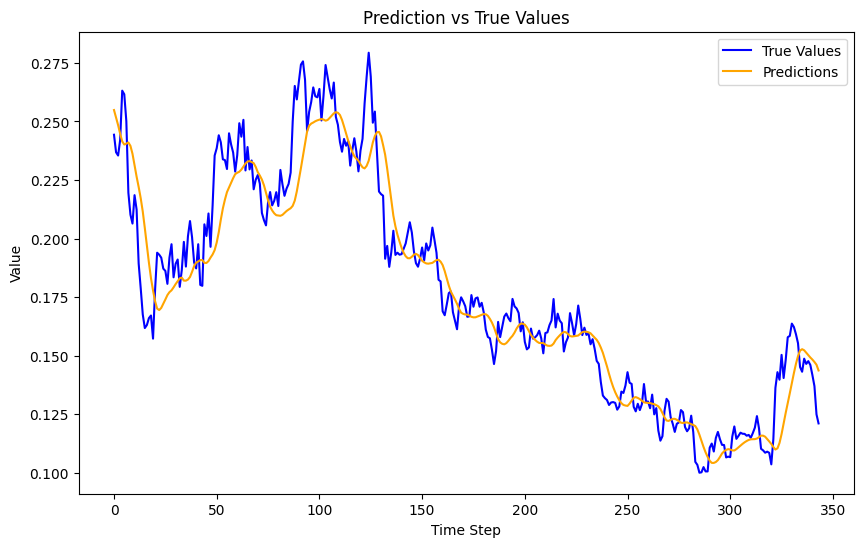

In [ ]:
# Prepare Data
def prepare_data(df, sequence_length, target_column='close'):
    # Train-test split (80% train, 20% test)
    split_idx = int(len(df) * 0.8)
    train_data = df[:split_idx]
    test_data = df[split_idx:]

    # Scale data
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)

    # Prepare sequences
    def create_sequences(data, seq_len, target_idx):
        x, y = [], []
        for i in range(len(data) - seq_len):
            x.append(data[i:i + seq_len, :-1])  # All features except the target
            y.append(data[i + seq_len, target_idx])  # Target column
        return np.array(x), np.array(y)

    target_idx = list(df.columns).index(target_column)
    x_train, y_train = create_sequences(train_scaled, sequence_length, target_idx)
    x_test, y_test = create_sequences(test_scaled, sequence_length, target_idx)

    return x_train, y_train, x_test, y_test, scaler

# Build LSTM Model
def build_model(configs, sequence_length, input_dim):
    model = Sequential()
    for layer in configs['model']['layers']:
        if layer['type'] == 'lstm':
            model.add(LSTM(
                layer['neurons'],
                activation='tanh',
                input_shape=(sequence_length, input_dim),
                return_sequences=layer['return_seq']
            ))
        elif layer['type'] == 'dropout':
            model.add(Dropout(layer['rate']))
        elif layer['type'] == 'dense':
            model.add(Dense(layer['neurons'], activation=layer['activation']))

    model.compile(optimizer=configs['model']['optimizer'], loss=configs['model']['loss'])
    return model

# Train Model
def train_model(model, x_train, y_train, configs):
    save_dir = configs['model']['save_dir']
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Save file path with the new `.keras` extension
    save_path = os.path.join(save_dir, "lstm_model.keras")
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=2),
        ModelCheckpoint(filepath=save_path, monitor='val_loss', save_best_only=True)
    ]

    model.fit(
        x_train,
        y_train,
        epochs=configs['training']['epochs'],
        batch_size=configs['training']['batch_size'],
        validation_split=0.1,
        callbacks=callbacks,
        verbose=1
    )
    # Explicitly save the final model
    model.save(save_path)
    print(f"Model saved to {save_path}")
    return model

# Predict & Evaluate
def predict_and_evaluate(model, x_test, y_test, scaler, num_features):
    predictions = model.predict(x_test)

    # Inverse transform predictions
    predictions = scaler.inverse_transform(
        np.concatenate([np.zeros((predictions.shape[0], num_features - 1)), predictions], axis=1)
    )[:, -1]

    # Inverse transform true values
    y_test = scaler.inverse_transform(
        np.concatenate([np.zeros((y_test.shape[0], num_features - 1)), y_test.reshape(-1, 1)], axis=1)
    )[:, -1]


# Main Function
if __name__ == "__main__":
    # Load data
    df = pd.read_csv("/content/drive/MyDrive/TS-project/price_news_integrate/aa.csv")
    df = df[['open', 'high', 'low', 'close', 'adj close', 'volume', 'scaled_sentiment']]
    df = df.dropna()

    # Hyperparameters & Configurations
    configs = {
        "data": {
            "sequence_length": 50,
            "target_column": "close"
        },
        "training": {
            "epochs": 20,
            "batch_size": 32
        },
        "model": {
            "loss": "mse",
            "optimizer": "adam",
            "save_dir": "saved_models",
            "layers": [
                {
                    "type": "lstm",
                    "neurons": 100,
                    "return_seq": True
                },
                {"type": "dropout", "rate": 0.2},
                {
                    "type": "lstm",
                    "neurons": 100,
                    "return_seq": False
                },
                {"type": "dropout", "rate": 0.2},
                {"type": "dense", "neurons": 1, "activation": "linear"}
            ]
        }
    }

    # Prepare data
    sequence_length = configs['data']['sequence_length']
    target_column = configs['data']['target_column']
    x_train, y_train, x_test, y_test, scaler = prepare_data(df, sequence_length, target_column)

    # Build, Train, and Predict
    num_features = df.shape[1]  # Automatically detect number of features
    input_dim = x_train.shape[2]  # Detect input dimensions for the model
    model = build_model(configs, sequence_length, input_dim)
    model = train_model(model, x_train, y_train, configs)
    predictions, y_test = predict_and_evaluate(model, x_test, y_test, scaler, num_features)

    # Evaluation
    results_eval = metrics(test=y_test, prediction=predictions)
    print(results_eval)

    # Plot predictions
    plot_predictions_LSTM(y_test, predictions)

[I 2024-12-19 08:06:19,039] A new study created in memory with name: no-name-fcb5a682-86e2-4ec4-b6fc-41a0a4fd7a15
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


[I 2024-12-19 08:06:35,733] Trial 0 finished with value: 0.00882207937194037 and parameters: {'sequence_length': 51, 'neurons_lstm': 110, 'dropout_rate': 0.4369969745043262, 'learning_rate': 0.008827323638797136, 'batch_size': 44, 'optimizer': 'adam'}. Best is trial 0 with value: 0.00882207937194037.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


[I 2024-12-19 08:07:51,961] Trial 1 finished with value: 0.009074901605299548 and parameters: {'sequence_length': 80, 'neurons_lstm': 133, 'dropout_rate': 0.3585503671319067, 'learning_rate': 0.0001491862602331279, 'batch_size': 22, 'optimizer': 'adam'}. Best is trial 0 with value: 0.00882207937194037.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


[I 2024-12-19 08:08:23,840] Trial 2 finished with value: 0.008138211889781716 and parameters: {'sequence_length': 65, 'neurons_lstm': 146, 'dropout_rate': 0.29501013186796243, 'learning_rate': 0.0019956332645375855, 'batch_size': 45, 'optimizer': 'adam'}. Best is trial 2 with value: 0.008138211889781716.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-12-19 08:08:53,687] Trial 3 finished with value: 0.008530895089948577 and parameters: {'sequence_length': 94, 'neurons_lstm': 86, 'dropout_rate': 0.21318979232889257, 'learning_rate': 0.0010242856176942874, 'batch_size': 16, 'optimizer': 'adam'}. Best is trial 2 with value: 0.008138211889781716.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


[I 2024-12-19 08:09:14,639] Trial 4 finished with value: 0.021732972439117208 and parameters: {'sequence_length': 37, 'neurons_lstm': 132, 'dropout_rate': 0.1780344042597554, 'learning_rate': 0.00015327124812931935, 'batch_size': 30, 'optimizer': 'rmsprop'}. Best is trial 2 with value: 0.008138211889781716.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


[I 2024-12-19 08:09:22,800] Trial 5 finished with value: 0.017326063143593525 and parameters: {'sequence_length': 91, 'neurons_lstm': 69, 'dropout_rate': 0.38596202604469476, 'learning_rate': 0.00073850669512307, 'batch_size': 52, 'optimizer': 'rmsprop'}. Best is trial 2 with value: 0.008138211889781716.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


[I 2024-12-19 08:09:54,191] Trial 6 finished with value: 0.058214557020829984 and parameters: {'sequence_length': 81, 'neurons_lstm': 129, 'dropout_rate': 0.36616598243967735, 'learning_rate': 0.008031962031619344, 'batch_size': 46, 'optimizer': 'rmsprop'}. Best is trial 2 with value: 0.008138211889781716.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


[I 2024-12-19 08:10:07,732] Trial 7 finished with value: 0.00886925154412734 and parameters: {'sequence_length': 71, 'neurons_lstm': 52, 'dropout_rate': 0.10552481585947278, 'learning_rate': 0.001014445923367111, 'batch_size': 36, 'optimizer': 'adam'}. Best is trial 2 with value: 0.008138211889781716.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


[I 2024-12-19 08:11:39,340] Trial 8 finished with value: 0.012514220359542123 and parameters: {'sequence_length': 47, 'neurons_lstm': 168, 'dropout_rate': 0.2980066952469682, 'learning_rate': 0.00017934421998170617, 'batch_size': 43, 'optimizer': 'rmsprop'}. Best is trial 2 with value: 0.008138211889781716.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


[I 2024-12-19 08:11:52,405] Trial 9 finished with value: 0.00913233196772398 and parameters: {'sequence_length': 49, 'neurons_lstm': 138, 'dropout_rate': 0.3444416156382742, 'learning_rate': 0.0019518541785873372, 'batch_size': 54, 'optimizer': 'adam'}. Best is trial 2 with value: 0.008138211889781716.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


[I 2024-12-19 08:12:11,015] Trial 10 finished with value: 0.007971018716640828 and parameters: {'sequence_length': 64, 'neurons_lstm': 195, 'dropout_rate': 0.49152900974253555, 'learning_rate': 0.0031724703435341973, 'batch_size': 60, 'optimizer': 'adam'}. Best is trial 10 with value: 0.007971018716640828.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


[I 2024-12-19 08:12:47,097] Trial 11 finished with value: 0.008684140122413649 and parameters: {'sequence_length': 63, 'neurons_lstm': 199, 'dropout_rate': 0.4765460251224032, 'learning_rate': 0.0028514629139334033, 'batch_size': 62, 'optimizer': 'adam'}. Best is trial 10 with value: 0.007971018716640828.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


[I 2024-12-19 08:13:08,649] Trial 12 finished with value: 0.008886669381397493 and parameters: {'sequence_length': 63, 'neurons_lstm': 196, 'dropout_rate': 0.2871672573057154, 'learning_rate': 0.00350772019606138, 'batch_size': 63, 'optimizer': 'adam'}. Best is trial 10 with value: 0.007971018716640828.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


[I 2024-12-19 08:14:30,153] Trial 13 finished with value: 0.011399287205714 and parameters: {'sequence_length': 70, 'neurons_lstm': 167, 'dropout_rate': 0.24154320870056534, 'learning_rate': 0.0003620259443860317, 'batch_size': 54, 'optimizer': 'adam'}. Best is trial 10 with value: 0.007971018716640828.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


[I 2024-12-19 08:15:08,594] Trial 14 finished with value: 0.007814197984005029 and parameters: {'sequence_length': 57, 'neurons_lstm': 165, 'dropout_rate': 0.4744697325980303, 'learning_rate': 0.00518828971440632, 'batch_size': 34, 'optimizer': 'adam'}. Best is trial 14 with value: 0.007814197984005029.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


[I 2024-12-19 08:15:36,932] Trial 15 finished with value: 0.007897802040928475 and parameters: {'sequence_length': 32, 'neurons_lstm': 167, 'dropout_rate': 0.4805996144376122, 'learning_rate': 0.00407658073836306, 'batch_size': 33, 'optimizer': 'adam'}. Best is trial 14 with value: 0.007814197984005029.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


[I 2024-12-19 08:16:12,003] Trial 16 finished with value: 0.008196608632989466 and parameters: {'sequence_length': 30, 'neurons_lstm': 165, 'dropout_rate': 0.4226080768735451, 'learning_rate': 0.005537820827688227, 'batch_size': 34, 'optimizer': 'adam'}. Best is trial 14 with value: 0.007814197984005029.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


[I 2024-12-19 08:16:24,236] Trial 17 finished with value: 0.009020302208774648 and parameters: {'sequence_length': 40, 'neurons_lstm': 106, 'dropout_rate': 0.43847695933616426, 'learning_rate': 0.00546904630391813, 'batch_size': 27, 'optimizer': 'adam'}. Best is trial 14 with value: 0.007814197984005029.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


[I 2024-12-19 08:16:36,091] Trial 18 finished with value: 0.02141795877447853 and parameters: {'sequence_length': 30, 'neurons_lstm': 153, 'dropout_rate': 0.4854603787476243, 'learning_rate': 0.0015106789582216154, 'batch_size': 37, 'optimizer': 'rmsprop'}. Best is trial 14 with value: 0.007814197984005029.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step


[I 2024-12-19 08:17:05,320] Trial 19 finished with value: 0.007706269709079577 and parameters: {'sequence_length': 44, 'neurons_lstm': 171, 'dropout_rate': 0.41667925412968965, 'learning_rate': 0.004877864302499309, 'batch_size': 27, 'optimizer': 'adam'}. Best is trial 19 with value: 0.007706269709079577.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


[I 2024-12-19 08:19:05,132] Trial 20 finished with value: 0.008622038920386214 and parameters: {'sequence_length': 55, 'neurons_lstm': 180, 'dropout_rate': 0.4045896447514906, 'learning_rate': 0.0005724320325778903, 'batch_size': 24, 'optimizer': 'adam'}. Best is trial 19 with value: 0.007706269709079577.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


[I 2024-12-19 08:19:43,693] Trial 21 finished with value: 0.00837120745354438 and parameters: {'sequence_length': 41, 'neurons_lstm': 179, 'dropout_rate': 0.45932931069118244, 'learning_rate': 0.004983314231560381, 'batch_size': 32, 'optimizer': 'adam'}. Best is trial 19 with value: 0.007706269709079577.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


[I 2024-12-19 08:20:22,236] Trial 22 finished with value: 0.00820957638755285 and parameters: {'sequence_length': 43, 'neurons_lstm': 153, 'dropout_rate': 0.4982409098987758, 'learning_rate': 0.004479856411362621, 'batch_size': 19, 'optimizer': 'adam'}. Best is trial 19 with value: 0.007706269709079577.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


[I 2024-12-19 08:21:17,229] Trial 23 finished with value: 0.008388238530871608 and parameters: {'sequence_length': 56, 'neurons_lstm': 175, 'dropout_rate': 0.45232798022010434, 'learning_rate': 0.00889642162620813, 'batch_size': 39, 'optimizer': 'adam'}. Best is trial 19 with value: 0.007706269709079577.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


[I 2024-12-19 08:21:36,280] Trial 24 finished with value: 0.009064915370106728 and parameters: {'sequence_length': 34, 'neurons_lstm': 154, 'dropout_rate': 0.39560244982390774, 'learning_rate': 0.0023030981498442416, 'batch_size': 28, 'optimizer': 'adam'}. Best is trial 19 with value: 0.007706269709079577.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


[I 2024-12-19 08:22:54,072] Trial 25 finished with value: 0.0070945803679115325 and parameters: {'sequence_length': 57, 'neurons_lstm': 185, 'dropout_rate': 0.3323208013626243, 'learning_rate': 0.00654153842597895, 'batch_size': 25, 'optimizer': 'adam'}. Best is trial 25 with value: 0.0070945803679115325.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


[I 2024-12-19 08:23:27,450] Trial 26 finished with value: 0.021217752659739908 and parameters: {'sequence_length': 56, 'neurons_lstm': 186, 'dropout_rate': 0.32217011998899137, 'learning_rate': 0.006701527682063575, 'batch_size': 25, 'optimizer': 'rmsprop'}. Best is trial 25 with value: 0.0070945803679115325.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


[I 2024-12-19 08:24:14,014] Trial 27 finished with value: 0.008047678286094014 and parameters: {'sequence_length': 58, 'neurons_lstm': 187, 'dropout_rate': 0.2510264228563319, 'learning_rate': 0.0014486868818905233, 'batch_size': 22, 'optimizer': 'adam'}. Best is trial 25 with value: 0.0070945803679115325.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


[I 2024-12-19 08:24:55,629] Trial 28 finished with value: 0.008070329603335485 and parameters: {'sequence_length': 46, 'neurons_lstm': 159, 'dropout_rate': 0.42021821492516775, 'learning_rate': 0.006109485094545584, 'batch_size': 30, 'optimizer': 'adam'}. Best is trial 25 with value: 0.0070945803679115325.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


[I 2024-12-19 08:25:13,497] Trial 29 finished with value: 0.008106536102336059 and parameters: {'sequence_length': 52, 'neurons_lstm': 120, 'dropout_rate': 0.3280602285701188, 'learning_rate': 0.009096832898692795, 'batch_size': 18, 'optimizer': 'adam'}. Best is trial 25 with value: 0.0070945803679115325.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


[I 2024-12-19 08:26:16,520] Trial 30 finished with value: 0.00737138579389505 and parameters: {'sequence_length': 74, 'neurons_lstm': 187, 'dropout_rate': 0.37995067065134036, 'learning_rate': 0.0025719692206790253, 'batch_size': 41, 'optimizer': 'adam'}. Best is trial 25 with value: 0.0070945803679115325.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step


[I 2024-12-19 08:27:07,359] Trial 31 finished with value: 0.007290505694320439 and parameters: {'sequence_length': 77, 'neurons_lstm': 189, 'dropout_rate': 0.3859887026680735, 'learning_rate': 0.0027313246429312597, 'batch_size': 42, 'optimizer': 'adam'}. Best is trial 25 with value: 0.0070945803679115325.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


[I 2024-12-19 08:27:45,875] Trial 32 finished with value: 0.007844806769597628 and parameters: {'sequence_length': 79, 'neurons_lstm': 190, 'dropout_rate': 0.36968119721227705, 'learning_rate': 0.002684090181582445, 'batch_size': 42, 'optimizer': 'adam'}. Best is trial 25 with value: 0.0070945803679115325.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


[I 2024-12-19 08:28:15,120] Trial 33 finished with value: 0.009151869764730489 and parameters: {'sequence_length': 75, 'neurons_lstm': 177, 'dropout_rate': 0.323832763040466, 'learning_rate': 0.0016276463637696925, 'batch_size': 46, 'optimizer': 'adam'}. Best is trial 25 with value: 0.0070945803679115325.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


[I 2024-12-19 08:29:11,134] Trial 34 finished with value: 0.007331511132662539 and parameters: {'sequence_length': 89, 'neurons_lstm': 186, 'dropout_rate': 0.3545256956049782, 'learning_rate': 0.0037119821214599007, 'batch_size': 48, 'optimizer': 'adam'}. Best is trial 25 with value: 0.0070945803679115325.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


[I 2024-12-19 08:29:56,278] Trial 35 finished with value: 0.0074335470490932195 and parameters: {'sequence_length': 88, 'neurons_lstm': 200, 'dropout_rate': 0.34909066169685127, 'learning_rate': 0.0036708241297735335, 'batch_size': 48, 'optimizer': 'adam'}. Best is trial 25 with value: 0.0070945803679115325.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step


[I 2024-12-19 08:30:35,195] Trial 36 finished with value: 0.007947129705390667 and parameters: {'sequence_length': 85, 'neurons_lstm': 144, 'dropout_rate': 0.37674759801611146, 'learning_rate': 0.0022862334368529994, 'batch_size': 49, 'optimizer': 'adam'}. Best is trial 25 with value: 0.0070945803679115325.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step


[I 2024-12-19 08:32:00,648] Trial 37 finished with value: 0.029054367290391597 and parameters: {'sequence_length': 99, 'neurons_lstm': 186, 'dropout_rate': 0.2679655082325525, 'learning_rate': 0.007084207807097897, 'batch_size': 40, 'optimizer': 'rmsprop'}. Best is trial 25 with value: 0.0070945803679115325.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


[I 2024-12-19 08:32:21,804] Trial 38 finished with value: 0.009235017665774262 and parameters: {'sequence_length': 70, 'neurons_lstm': 183, 'dropout_rate': 0.3425878039399879, 'learning_rate': 0.0012797062574884132, 'batch_size': 50, 'optimizer': 'adam'}. Best is trial 25 with value: 0.0070945803679115325.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


[I 2024-12-19 08:33:02,172] Trial 39 finished with value: 0.012935932173775715 and parameters: {'sequence_length': 84, 'neurons_lstm': 94, 'dropout_rate': 0.310981091431417, 'learning_rate': 0.0019033786726300535, 'batch_size': 42, 'optimizer': 'rmsprop'}. Best is trial 25 with value: 0.0070945803679115325.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


[I 2024-12-19 08:34:31,170] Trial 40 finished with value: 0.008044342918282018 and parameters: {'sequence_length': 77, 'neurons_lstm': 189, 'dropout_rate': 0.19216488412948407, 'learning_rate': 0.0008577851686098426, 'batch_size': 56, 'optimizer': 'adam'}. Best is trial 25 with value: 0.0070945803679115325.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


[I 2024-12-19 08:35:22,507] Trial 41 finished with value: 0.006996523597052514 and parameters: {'sequence_length': 90, 'neurons_lstm': 198, 'dropout_rate': 0.35831051619913984, 'learning_rate': 0.0036478182178277603, 'batch_size': 48, 'optimizer': 'adam'}. Best is trial 41 with value: 0.006996523597052514.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step


[I 2024-12-19 08:35:58,541] Trial 42 finished with value: 0.007420699865951527 and parameters: {'sequence_length': 95, 'neurons_lstm': 191, 'dropout_rate': 0.3684098416694673, 'learning_rate': 0.002778442937102072, 'batch_size': 46, 'optimizer': 'adam'}. Best is trial 41 with value: 0.006996523597052514.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


[I 2024-12-19 08:37:22,177] Trial 43 finished with value: 0.009895295293551178 and parameters: {'sequence_length': 91, 'neurons_lstm': 200, 'dropout_rate': 0.3894711531301491, 'learning_rate': 0.003734154694338367, 'batch_size': 44, 'optimizer': 'adam'}. Best is trial 41 with value: 0.006996523597052514.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


[I 2024-12-19 08:38:03,721] Trial 44 finished with value: 0.008573749943525189 and parameters: {'sequence_length': 83, 'neurons_lstm': 176, 'dropout_rate': 0.35498738883473135, 'learning_rate': 0.00752975615513401, 'batch_size': 38, 'optimizer': 'adam'}. Best is trial 41 with value: 0.006996523597052514.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


[I 2024-12-19 08:38:16,398] Trial 45 finished with value: 0.010237065913403072 and parameters: {'sequence_length': 75, 'neurons_lstm': 74, 'dropout_rate': 0.2902147059127213, 'learning_rate': 0.0024160247317084357, 'batch_size': 51, 'optimizer': 'adam'}. Best is trial 41 with value: 0.006996523597052514.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


[I 2024-12-19 08:39:12,626] Trial 46 finished with value: 0.007215968210895187 and parameters: {'sequence_length': 87, 'neurons_lstm': 195, 'dropout_rate': 0.33838489975903074, 'learning_rate': 0.0032367618666250173, 'batch_size': 47, 'optimizer': 'adam'}. Best is trial 41 with value: 0.006996523597052514.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


[I 2024-12-19 08:40:07,499] Trial 47 finished with value: 0.017502965509543028 and parameters: {'sequence_length': 90, 'neurons_lstm': 195, 'dropout_rate': 0.3324780303936972, 'learning_rate': 0.003148817521126753, 'batch_size': 57, 'optimizer': 'rmsprop'}. Best is trial 41 with value: 0.006996523597052514.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


[I 2024-12-19 08:41:28,100] Trial 48 finished with value: 0.006716041159205205 and parameters: {'sequence_length': 96, 'neurons_lstm': 193, 'dropout_rate': 0.10940523733295832, 'learning_rate': 0.00419732684404695, 'batch_size': 52, 'optimizer': 'adam'}. Best is trial 48 with value: 0.006716041159205205.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


[I 2024-12-19 08:42:09,206] Trial 49 finished with value: 0.01036653185567771 and parameters: {'sequence_length': 96, 'neurons_lstm': 194, 'dropout_rate': 0.27842122219232934, 'learning_rate': 0.00022015291013830515, 'batch_size': 53, 'optimizer': 'adam'}. Best is trial 48 with value: 0.006716041159205205.


Best Hyperparameters:
{'sequence_length': 96, 'neurons_lstm': 193, 'dropout_rate': 0.10940523733295832, 'learning_rate': 0.00419732684404695, 'batch_size': 52, 'optimizer': 'adam'}
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 243ms/step - loss: 0.0335 - val_loss: 0.0114
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 208ms/step - loss: 9.2298e-04 - val_loss: 0.0032
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 217ms/step - loss: 6.3961e-04 - val_loss: 0.0030
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 300ms/step - loss: 4.4949e-04 - val_loss: 0.0026
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 208ms/step - loss: 3.8250e-04 - val_loss: 0.0025
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 305ms/step - loss: 3.4986e-04 - val_loss: 0.0026
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 208ms/step - loss: 3.6786e-04 - val_loss: 0.0025
Epoch 7: early stopping
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Final Model MAE: 0.0073


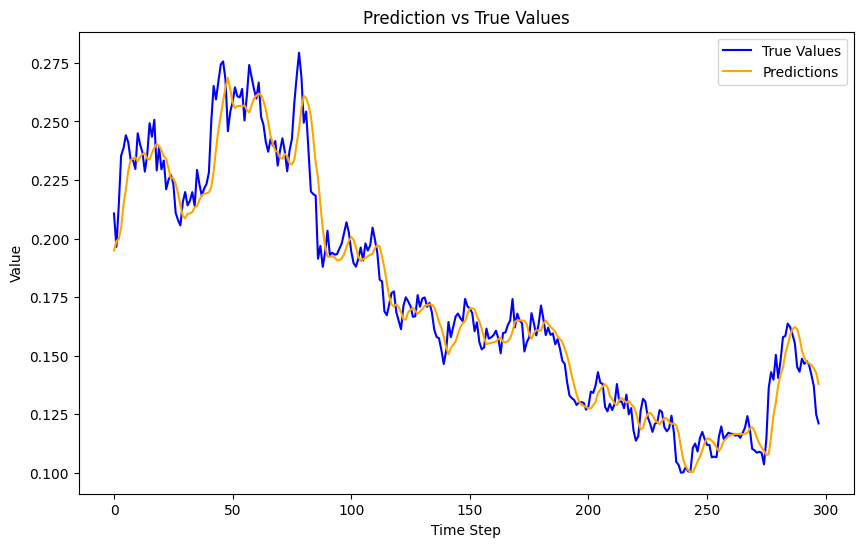

In [ ]:
# Prepare Data
def prepare_data(df, sequence_length, target_column='close'):
    split_idx = int(len(df) * 0.8)
    train_data = df[:split_idx]
    test_data = df[split_idx:]

    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)

    def create_sequences(data, seq_len, target_idx):
        x, y = [], []
        for i in range(len(data) - seq_len):
            x.append(data[i:i + seq_len, :-1])  # All features except target
            y.append(data[i + seq_len, target_idx])  # Target column
        return np.array(x), np.array(y)

    target_idx = list(df.columns).index(target_column)
    x_train, y_train = create_sequences(train_scaled, sequence_length, target_idx)
    x_test, y_test = create_sequences(test_scaled, sequence_length, target_idx)

    return x_train, y_train, x_test, y_test, scaler

# Objective Function for Optuna
def objective(trial,df):
    # Hyperparameter Tuning
    sequence_length = trial.suggest_int('sequence_length', 30, 100)
    neurons_lstm = trial.suggest_int('neurons_lstm', 50, 200)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_int('batch_size', 16, 64)
    optimizer_choice = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])

    # Prepare data
    x_train, y_train, x_test, y_test, scaler = prepare_data(df, sequence_length, target_column='close')
    input_dim = x_train.shape[2]

    # Build model
    model = Sequential()
    model.add(LSTM(neurons_lstm, activation='tanh', input_shape=(sequence_length, input_dim), return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))

    optimizer = Adam(learning_rate=learning_rate) if optimizer_choice == 'adam' else RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')

    # Train model
    model.fit(
        x_train,
        y_train,
        validation_split=0.1,
        epochs=20,  # Fixed number of epochs for tuning
        batch_size=batch_size,
        verbose=0,
        callbacks=[EarlyStopping(monitor='val_loss', patience=2, verbose=0)]
    )

    # Evaluate model
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(np.concatenate([np.zeros((predictions.shape[0], df.shape[1] - 1)), predictions], axis=1))[:, -1]
    y_test = scaler.inverse_transform(np.concatenate([np.zeros((y_test.shape[0], df.shape[1] - 1)), y_test.reshape(-1, 1)], axis=1))[:, -1]

    mae = mean_absolute_error(y_test, predictions)
    return mae

# Optuna Optimization
def tune_hyperparameters(df):
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, df), n_trials=50)

    print("Best Hyperparameters:")
    print(study.best_params)

    return study.best_params

# Main Function
if __name__ == "__main__":
    # Load data
    df = pd.read_csv("/content/drive/MyDrive/TS-project/price_news_integrate/aa.csv")
    df = df[['open', 'high', 'low', 'close', 'adj close', 'volume', 'scaled_sentiment']]
    df = df.dropna()

    # Hyperparameter Tuning
    best_params = tune_hyperparameters()

    # Use the best hyperparameters for final training
    x_train, y_train, x_test, y_test, scaler = prepare_data(df, best_params['sequence_length'], target_column='close')

    model = Sequential()
    model.add(LSTM(best_params['neurons_lstm'], activation='tanh', input_shape=(best_params['sequence_length'], x_train.shape[2]), return_sequences=False))
    model.add(Dropout(best_params['dropout_rate']))
    model.add(Dense(1, activation='linear'))

    optimizer = Adam(learning_rate=best_params['learning_rate']) if best_params['optimizer'] == 'adam' else RMSprop(learning_rate=best_params['learning_rate'])
    model.compile(optimizer=optimizer, loss='mse')

    model.fit(
        x_train,
        y_train,
        validation_split=0.1,
        epochs=20,
        batch_size=best_params['batch_size'],
        callbacks=[EarlyStopping(monitor='val_loss', patience=2, verbose=1)],
        verbose=1
    )

    # Evaluate final model
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(np.concatenate([np.zeros((predictions.shape[0], df.shape[1] - 1)), predictions], axis=1))[:, -1]
    y_test = scaler.inverse_transform(np.concatenate([np.zeros((y_test.shape[0], df.shape[1] - 1)), y_test.reshape(-1, 1)], axis=1))[:, -1]



    # Evaluation
    results_eval = metrics(test=y_test, prediction=predictions)
    print(results_eval)

    # Plot predictions
    plot_predictions_LSTM(y_test, predictions)


## **3 - ARIMA**

In [21]:
df = pd.read_csv("/content/drive/MyDrive/TS-project/price_news_integrate/aa.csv")

In [193]:
data = df['close']  # This is your time-series data

# Perform the Dickey-Fuller Test
result = adfuller(data)
print("ADF Statistic:", result[0])
print("p-value:", result[1])  # If p-value < 0.05, the data is stationary


ADF Statistic: -1.9392381819966469
p-value: 0.3138332233238764


**Data is non-stationary**, need to remove trends and seasonality, use log transformation. Let's just go through the ARIMA **without further data transformations**. **We expect bad results.**

In [54]:
def arima(df, target_column='close', train_ratio=0.8, order=(5, 1, 0)):

    # Extract the target column
    data = df[target_column]

    # Split data into training and testing sets
    train_size = int(len(data) * train_ratio)
    train, test = data[:train_size], data[train_size:]

    # Fit the ARIMA model
    print("Fitting ARIMA model...")
    model = ARIMA(train, order=order)
    fitted_model = model.fit()

    # Forecast on test data
    prediction = fitted_model.forecast(steps=len(test))


    # Plot
    plot_arima_results(train=train, test=test, prediction=prediction, target_column='close')

    # Metrics
    metrics_results = metrics(test,prediction)
    print(metrics_results)



In [55]:
def arima_with_optuna(df, target_column='close', train_ratio=0.8):

    # Extract the target column
    data = df[target_column]

    # Split data into training and testing sets
    train_size = int(len(data) * train_ratio)
    train, test = data[:train_size], data[train_size:]

    # Define the objective function for Optuna
    def objective(trial):
        # Suggest hyperparameters
        p = trial.suggest_int('p', 0, 5)
        d = trial.suggest_int('d', 0, 2)
        q = trial.suggest_int('q', 0, 5)
        try:
            # Fit ARIMA model
            model = ARIMA(train, order=(p, d, q))
            fitted_model = model.fit()
            prediction = fitted_model.forecast(steps=len(test))
            return mean_squared_error(test, prediction)
        except:
            return float('inf')

    # Run Optuna optimization
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    # Get the best parameters
    best_params = study.best_params
    print(f"Best ARIMA parameters: {best_params}")

    # Fit and evaluate with best parameters
    best_model = ARIMA(train, order=(best_params['p'], best_params['d'], best_params['q']))
    fitted_model = best_model.fit()
    prediction = fitted_model.forecast(steps=len(test))


    # Plot
    plot_arima_results(train=train, test=test, prediction=prediction, target_column='close')

    # Metrics
    metrics_results = metrics(test,prediction)
    print(metrics_results)

Fitting ARIMA model...


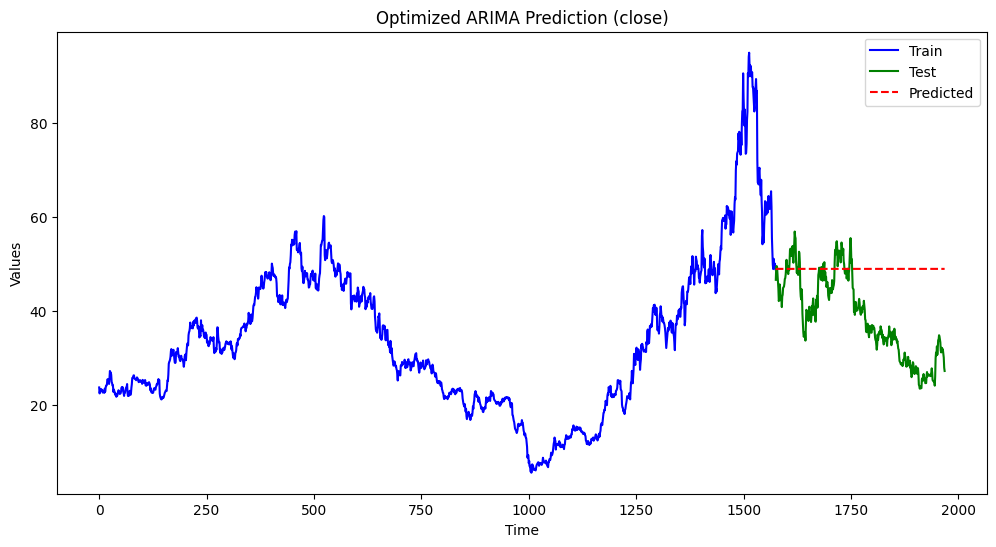

  eval       score
0  MAE   11.092536
1  MSE  180.905847
2   R2   -1.339618


In [56]:
arima(df, target_column='close', train_ratio=0.8, order=(5, 1, 0))

[I 2024-12-19 15:29:37,499] A new study created in memory with name: no-name-ef790e94-70d0-404d-9af4-4cc8831a864f
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2024-12-19 15:29:45,124] Trial 0 finished with value: 171.50344987223986 and parameters: {'p': 4, 'd': 1, 'q': 4}. Best is trial 0 with value: 171.50344987223986.
[I 2024-12-19 15:29:50,919] Trial 1 finished with value: 51.27493948869203 and parameters: {'p': 1, 'd': 0, 'q': 3}. Best is trial 1 with value: 51.27493948869203.
[I 2024-12-19 15:29:54,831] Trial 2 finished with value: 185.16088716999985 and parameters: {'p': 1, 'd': 1, 'q': 5}. Best is trial 1 with value: 51.27493948869203.
[I 2024-12-19 15:29:55,647] Trial 3 finished with value: 8407.07775294258 and parameters: {'p': 3, 'd': 2, 'q': 0}. Best is trial 1 with value: 51.27493948869203.
[I 202

Best ARIMA parameters: {'p': 3, 'd': 0, 'q': 1}
MAE: 6.1190
MSE: 51.1243
R²: 0.3388


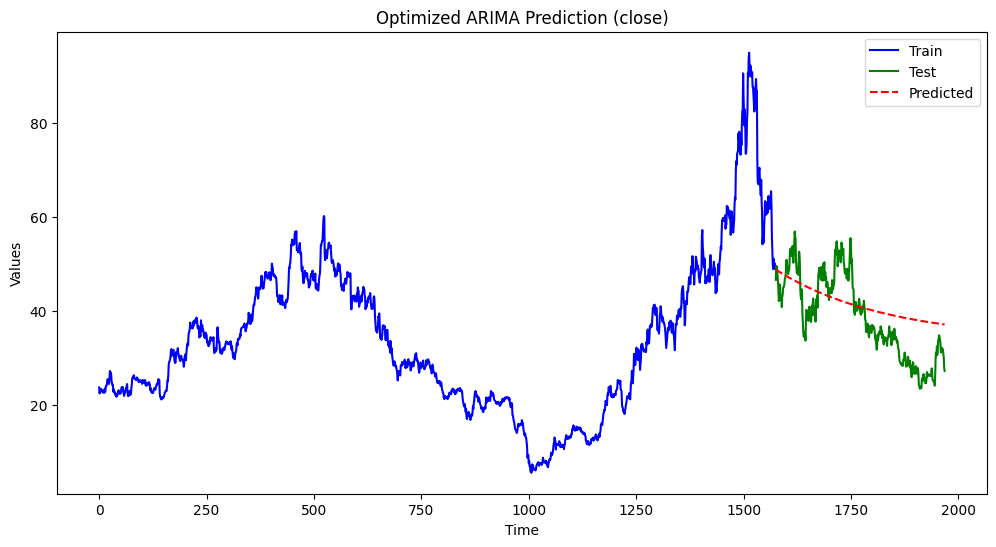

In [187]:
arima_with_optuna(df, target_column='close', train_ratio=0.8)